In [14]:
from collections import Counter

import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from wordcloud import WordCloud

In [3]:
# load the dataset
dataset_timeseries_path = "data/_raw_df_timeseries.tsv"
df_timeseries_by_channel = pd.read_csv(dataset_timeseries_path, sep="\t")
df_timeseries_by_channel = df_timeseries_by_channel[df_timeseries_by_channel["category"] == "Sports"]

df_timeseries_by_channel["datetime"] = pd.to_datetime(df_timeseries_by_channel["datetime"], format="%Y-%m-%d %H:%M:%S")
df_timeseries_by_channel["year"] = df_timeseries_by_channel["datetime"].dt.year
df_timeseries_by_channel["month"] = df_timeseries_by_channel["datetime"].dt.month
df_timeseries_by_channel["day"] = df_timeseries_by_channel["datetime"].dt.day




# load the dataset
dataset_video_path = "data/filtered_sport_category_metadata.parquet"
df_video = pd.read_parquet(dataset_video_path, engine="fastparquet")

# convert the upload_date column to datetime
df_video["upload_date"] = pd.to_datetime(df_video["upload_date"], format="%Y-%m-%d %H:%M:%S")
df_video["year"] = df_video["upload_date"].dt.year
df_video["month"] = df_video["upload_date"].dt.month
df_video["day"] = df_video["upload_date"].dt.day

# convert the tags into the ones with only small letters
df_video["tags"] = df_video["tags"].apply(lambda x: x.lower())

df_video["like_to_view_ratio"] = df_video["like_count"] / df_video["view_count"]
df_video["dislike_to_view_ratio"] = df_video["dislike_count"] / df_video["view_count"]
df_video["like_to_dislike_ratio"] = df_video["like_count"] / df_video["dislike_count"]

# drop columns that are not needed
df_video.drop(columns=["crawl_date", "display_id", "like_count", "dislike_count"], inplace=True)

# bug??
df_video = df_video[df_video["like_to_view_ratio"] <= 1]
df_video = df_video[df_video["dislike_to_view_ratio"] <= 1]



# load the dataset
dataset_channel_path = "data/df_channels_en.tsv"
df_channel = pd.read_csv(dataset_channel_path, sep="\t")
df_channel = df_channel[df_channel["category_cc"] == "Sports"]

# Timeseries

In [17]:
df_timeseries_by_channel

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,year,month,day
1596,UCNTpErdUqTDqWq7YG1nasOQ,Sports,2016-02-08,2.649723e+06,6505.000000,3505.000000,0.000000,241,0,0,2016,2,8
1597,UCNTpErdUqTDqWq7YG1nasOQ,Sports,2016-02-15,2.661633e+06,11909.875000,3523.000000,18.000000,241,0,0,2016,2,15
1598,UCNTpErdUqTDqWq7YG1nasOQ,Sports,2016-02-22,2.674360e+06,12726.625000,3537.250000,14.250000,241,0,0,2016,2,22
1599,UCNTpErdUqTDqWq7YG1nasOQ,Sports,2016-02-29,2.687528e+06,13168.625000,3552.625000,15.375000,241,0,0,2016,2,29
1600,UCNTpErdUqTDqWq7YG1nasOQ,Sports,2016-03-07,2.701620e+06,14091.875000,3571.000000,18.375000,241,0,0,2016,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21553288,UCLV-Fynzx2bc3WxF8-goCvA,Sports,2019-09-02,3.857756e+06,23270.000000,35128.833333,206.388889,11,0,0,2019,9,2
21553289,UCLV-Fynzx2bc3WxF8-goCvA,Sports,2019-09-09,3.870991e+06,13234.666667,35221.000000,92.166667,11,0,0,2019,9,9
21553290,UCLV-Fynzx2bc3WxF8-goCvA,Sports,2019-09-16,3.883723e+06,12732.100000,35310.000000,89.000000,11,0,0,2019,9,16
21553291,UCLV-Fynzx2bc3WxF8-goCvA,Sports,2019-09-23,3.893440e+06,9716.700000,35380.000000,70.000000,11,0,0,2019,9,23


<Axes: xlabel='year,month'>

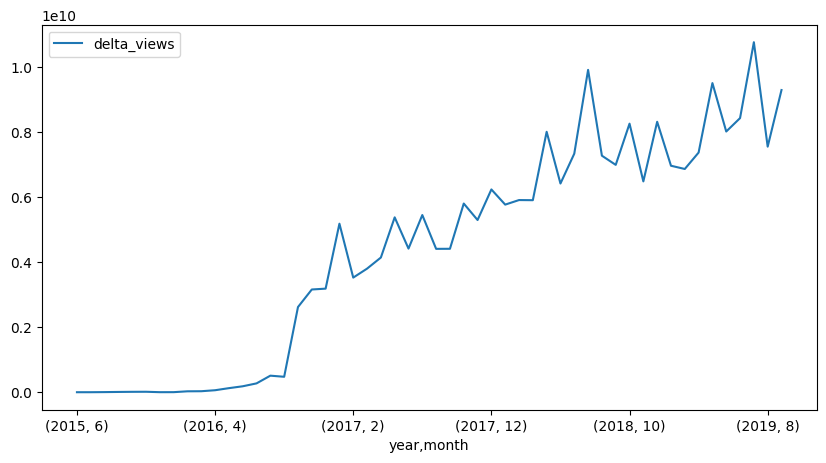

In [21]:
df_timeseries_by_channel[["year", "month", "delta_views"]].groupby(["year", "month"]).sum().plot(figsize=(10, 5))

# Video

In [49]:
df_video

,categories,channel_id,description,duration,tags,title,upload_date,view_count,year,month,day,like_to_view_ratio,dislike_to_view_ratio,like_to_dislike_ratio
0,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,Can I catch 100 lbs of catfish LIVE. Me and Ja...,8620,"catfishing,fishing,fishing challenge,catfish,c...",Catching 100 lbs of Catfish 🔴Live,2019-10-01,48737.0,2019,10,1,0.034327,0.000718,47.800000
1,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,,355,,big cat,2019-10-01,19999.0,2019,10,1,0.064853,0.000750,86.466667
2,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,Are you ready to enter the high fashion world ...,603,"catfishing,how to catch catfish,fishing,classy...",Classy Catfishing - How to Catch Catfish the P...,2019-09-28,58518.0,2019,9,28,0.056478,0.001333,42.371795
3,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,Saltwater fishing out of Newquay Cornwall UK. ...,1426,"fishing,fishing uk,angling,sea angling,sea ang...",2 Day Saltwater Fishing Catch & Cook - UK Sea ...,2019-09-21,71998.0,2019,9,21,0.026237,0.000972,26.985714
4,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,My family spent 3 weeks touring England and fi...,990,"fishing,catfish,wels catfish,how to catch catf...",How to Catch Wels Catfish - Fishing for Catfis...,2019-09-14,101924.0,2019,9,14,0.026481,0.000716,36.972603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4354407,Sports,UCrwEMKhsjY8P9-GuIKMYVrQ,Play Confident Golf - it’s mental game too. I...,1121,"hypnosis,progressive hypnosis,meditation,calm,...",Play Better Golf Part 4 ★ Putting Precision ★ ...,2017-02-14,20430.0,2017,2,14,0.004356,0.000343,12.714286
4354408,Sports,UCrwEMKhsjY8P9-GuIKMYVrQ,Play Confident Golf - it’s mental game too. I...,1341,"hypnosis,progressive hypnosis,calm,hypnotherap...",Play Better Golf Part 3 ★ Owning The Tee ★ Hyp...,2017-02-14,25817.0,2017,2,14,0.003525,0.000504,7.000000
4354409,Sports,UCrwEMKhsjY8P9-GuIKMYVrQ,Play Confident Golf - it’s mental game too. I...,1098,"hypnosis,progressive hypnosis,meditation,calm,...",Play Better Golf Part 2 ★ Fairway and Approach...,2017-02-14,29909.0,2017,2,14,0.003845,0.000635,6.052632
4354410,Sports,UCrwEMKhsjY8P9-GuIKMYVrQ,Play Confident Golf - it's a mental game too. ...,1245,"hypnosis,progressive hypnosis,meditation,calm,...",Play Better Golf Part 1 ★ Getting In The Zone ...,2017-02-14,61980.0,2017,2,14,0.006002,0.000452,13.285714


### Distribution of duration

Longer videos increased

<Axes: xlabel='upload_date', ylabel='duration'>

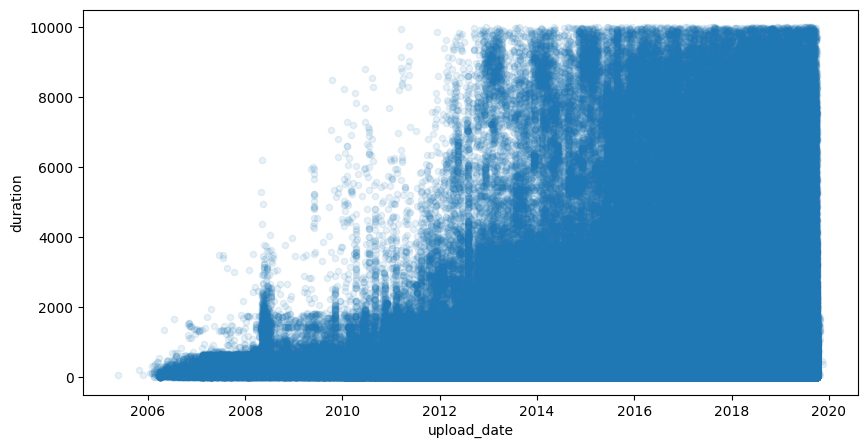

In [50]:
df_video[df_video["duration"] < 10000].plot.scatter(x="upload_date", y="duration", figsize=(10, 5), alpha=0.1)

### Popular videos

<Axes: xlabel='upload_date', ylabel='like_to_view_ratio'>

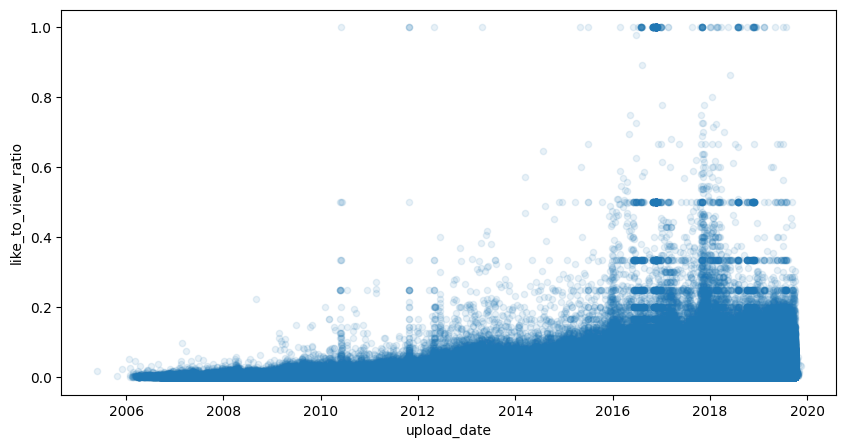

In [51]:
df_video[df_video["like_to_view_ratio"] != np.inf].plot.scatter(x="upload_date", y="like_to_view_ratio", figsize=(10, 5), alpha=0.1)

### Unpopular videos

<Axes: xlabel='upload_date', ylabel='dislike_to_view_ratio'>

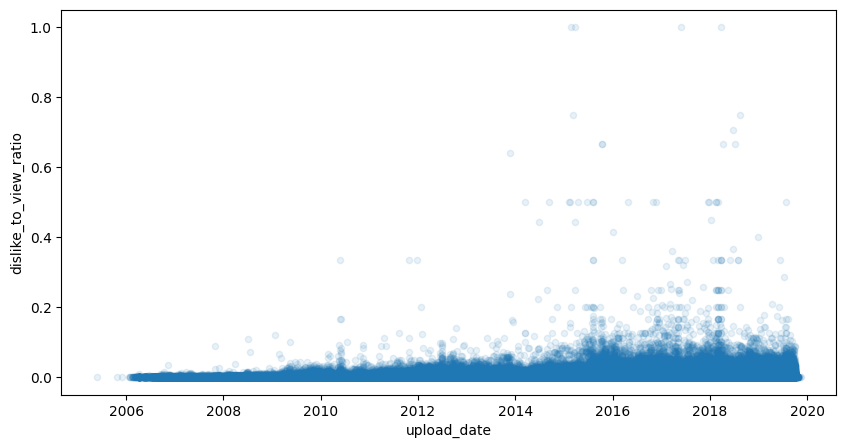

In [52]:
df_video[df_video["dislike_to_view_ratio"] != np.inf].plot.scatter(x="upload_date", y="dislike_to_view_ratio", figsize=(10, 5), alpha=0.1)

<Axes: xlabel='year'>

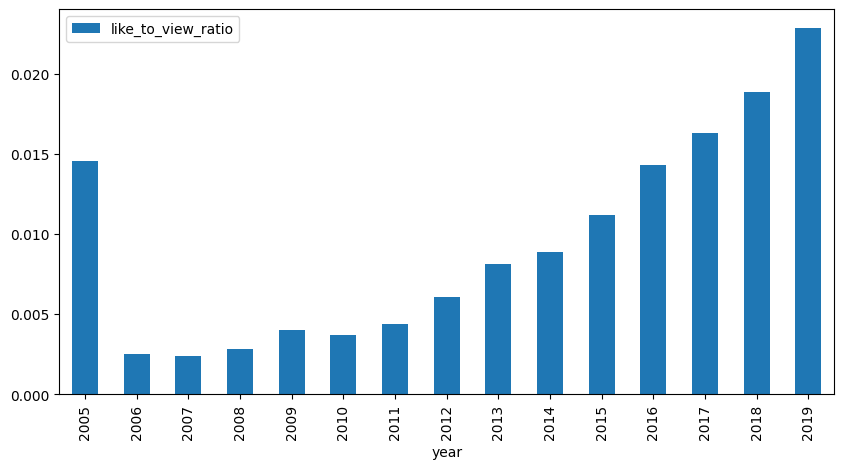

In [8]:
df_video[["year", "like_to_view_ratio"]].groupby("year").mean().plot.bar(y=["like_to_view_ratio"], figsize=(10, 5))

<Axes: xlabel='year'>

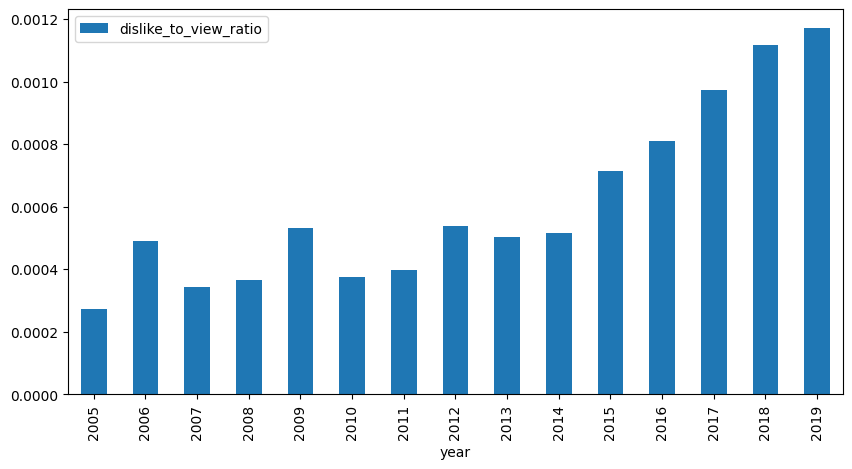

In [9]:
df_video[["year", "dislike_to_view_ratio"]].groupby("year").mean().plot.bar(y=["dislike_to_view_ratio"], figsize=(10, 5))

### Change in like/dislikes (like increased)

<Axes: xlabel='upload_date', ylabel='like_to_dislike_ratio'>

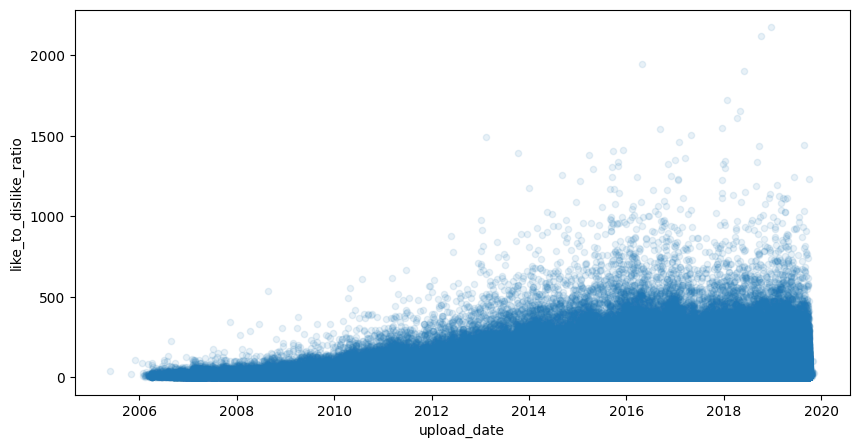

In [55]:
df_video.plot.scatter(x="upload_date", y="like_to_dislike_ratio", figsize=(10, 5), alpha=0.1)

### Contraversial games/videos

In [15]:
df_video[df_video["like_to_dislike_ratio"] != np.inf].sort_values(by="like_to_dislike_ratio", ascending=False).head(10)

,categories,channel_id,description,duration,tags,title,upload_date,view_count,year,month,day,like_to_view_ratio,dislike_to_view_ratio,like_to_dislike_ratio
3027551,Sports,UCFoez1Xjc90CsHvCzqKnLcw,WIN A YEAR'S SUPPLY OF TP5 or TP5x TaylorMade ...,91,"golf swing,golf lesson,golf tips,slice,how to,...",WIN A YEAR'S SUPPLY OF TP5 or TP5x TaylorMade ...,2018-12-20,9880.0,2018,12,20,0.440486,0.000202,2176.000000
4137061,Sports,UC0uRT_armQXqds_rjTjqJ0g,Inscreva-se na #SantosTV e fique por dentro de...,247,"santos,santos futebol clube,santos fc,santos t...",SANTOS SE REAPRESENTA E SE PREPARA PARA O CLÁS...,2018-10-08,13002.0,2018,10,8,0.162975,0.000077,2119.000000
4138305,Sports,UC0uRT_armQXqds_rjTjqJ0g,O meia Rafinha do Santos-AP foi até o vestiári...,44,"santos,santos futebol clube,santos fc,santos t...",Elano presenteia jogador do Santos (AP),2016-04-30,30003.0,2016,4,30,0.064794,0.000033,1944.000000
801215,Sports,UCiOGAwrae16q4-RJofo_rGA,► Shane Sparrow\nInstagram: https://www.instag...,509,"arms day,arms workout,biceps day,biceps workou...",760LB PLATE LOADED SPIDER LAT ROW WIDE BACK DAY,2018-06-04,12486.0,2018,6,4,0.152170,0.000080,1900.000000
1431900,Sports,UC_91rmL53N1srux25JOkQBw,----------------------------------------------...,252,"chad hoover,tutorial,fish weight formula,formu...",How to Get a Bass Weight without Scales | The ...,2018-01-24,8012.0,2018,1,24,0.214803,0.000125,1721.000000
3053450,Sports,UCvHCGRGpOI4VGz1OzmzkLaw,FIBO 2018 Aftermovie 🎥\nSeeing those scenes br...,131,"womensbest,fitness,fitspo,workout,training,mot...",FIBO 2018 Aftermovie | Women's Best,2018-04-29,67986.0,2018,4,29,0.048672,0.000029,1654.500000
3027714,Sports,UCFoez1Xjc90CsHvCzqKnLcw,THE MASTERS HAUL GIVEAWAY!!!!!\n\n►GolfAlong I...,246,"golf swing,golf lesson,golf tips,slice,how to,...",THE MASTERS HAUL GIVEAWAY!!!!!,2018-04-11,13329.0,2018,4,11,0.241353,0.000150,1608.500000
3067600,Sports,UCFHZHhZaH7Rc_FOMIzUziJA,DAY 5 - SANTA SHIELS HUGE CHRISTMAS GIVEAWAY\n...,147,"golf,golf tips,golf advice,how to play better ...",DAY 5 - SANTA SHIELS HUGE CHRISTMAS GIVEAWAY,2017-12-22,27628.0,2017,12,22,0.505067,0.000326,1550.444444
1453502,Sports,UCZovNYSIMVcbjgOzWhJy3zw,Make sure to SUBSCRIBE to East Coast Dyes for ...,121,"east,coast,dyes,lax,lacrosse,stringing,string,...",Greg's BIG Cascade + Pro Athletics Giveaway!,2016-09-07,12060.0,2016,9,7,0.255473,0.000166,1540.500000
3713061,Sports,UCuc2f9xbUqAfV4tIawajZDw,"Watch ""The Cannon"" doing what he does best in ...",176,"shannon briggs training motivation,the cannon,...",Shannon Briggs Training Motivation | The Canno...,2017-04-29,7144.0,2017,4,29,0.210246,0.000140,1502.000000


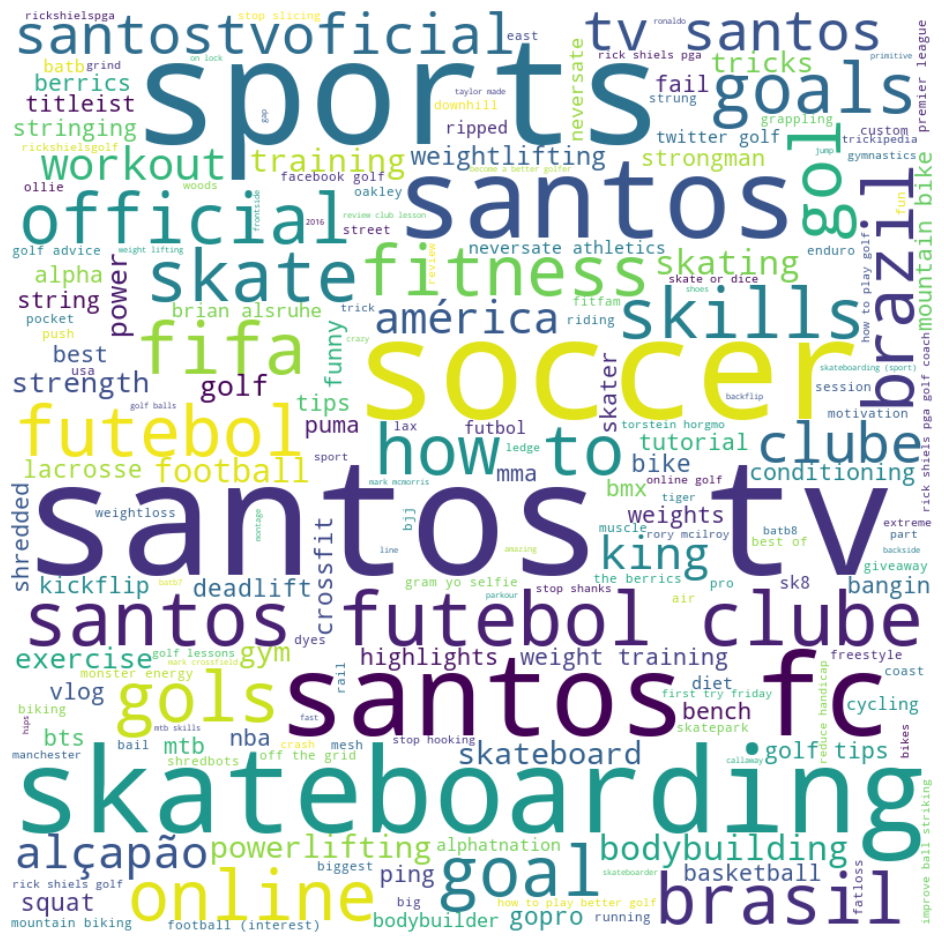

In [16]:
df_video_controversial = df_video[df_video["like_to_dislike_ratio"] != np.inf].sort_values(by="like_to_dislike_ratio", ascending=False).head(1000)

all_tags = [tag for sublist in df_video_controversial['tags'].str.split(',').tolist() for tag in sublist]

# Count the frequency of each tag
tag_counts = Counter(all_tags)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(tag_counts)

# Plot the word cloud
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Channel

In [11]:
df_channel

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.0870
7,Sports,2009-03-17,UCRijo3ddMTht_IHyNSNXpNQ,Dude Perfect,45800000,213,14.0,2.0870
203,Sports,2005-11-21,UCWJ2lWNubArHWmf3FIHbfcQ,NBA,11900000,31357,323.0,2.0870
266,Sports,2011-04-09,UCKvn9VBLAiLiYL4FFJHri6g,F2Freestylers - Ulti...,10700000,629,434.0,2.0870
350,Sports,2011-02-01,UCI4fHQkguBNW3SwTqmehzjw,DALLMYD,9010000,488,578.0,2.0870
...,...,...,...,...,...,...,...,...
136331,Sports,2017-04-05,UCaYD_DIzARK4XKqwfB-MQ0Q,TheAbominableLebron,10100,202,980809.0,53.1435
136405,Sports,2011-08-28,UCzibL3lQDdR-ZnyBcHtdMOQ,Oktaygun,10103,128,990235.0,53.1435
136425,Sports,2006-11-04,UCGRaw86VnDAK7_mqtLvoLkg,Sydney Sewell,10000,226,993735.0,53.1435
136426,Sports,2010-12-30,UCUtKgBcqduOxgZRog9KDvzg,KATUSHA Media,10038,213,994198.0,53.1435


## 1. select videos of minor sports

In [24]:
sport_name = "curling"

df_video_selected = df_video[df_video["tags"].str.contains(sport_name, case=False, na=False)]

pd.merge(df_video_selected, df_channel, left_on="channel_id", right_on="channel")

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,...,month,day,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Sports,UCqvMq4i8AsxkUQXErBFIe7g,2019-10-30 01:50:30.523192,Video brought to you by http://bmr.me/ It was...,1.0,8jlmBZv0aOQ,226,8.0,"fitness,fit,men,and,women,female,muscles,bench...",Fitness5 Tour- Tylösand day1,...,7,1,Sports,2007-03-23,UCqvMq4i8AsxkUQXErBFIe7g,FITNESS AND BEAUTY,54800,562,267818.0,6.3410
1,Sports,UCqhnX4jA0A5paNd1v-zEysw,2019-11-19 03:43:08.874628,Shot 100% on the HD HERO3+® camera from http:/...,143.0,kZMDKbfIis0,76,1221.0,"gopro,hero 2,hero 3,camera,hd cam,hd,rad,curli...",GoPro: Curling,...,2,6,Sports,2009-03-11,UCqhnX4jA0A5paNd1v-zEysw,GoPro,7810000,2096,762.0,2.0870
2,Sports,UCqZYv-GOxZdfr4-1huwBBwA,2019-10-30 04:52:59.265757,The first GW Slice of 2017 focuses in on what ...,0.0,StwDXpihlls,108,12.0,"golf,golfing world,pga tour,european tour,lee ...",GW Slice: ❄️️ The perils of winter golf ❄️️,...,1,17,Sports,2009-10-29,UCqZYv-GOxZdfr4-1huwBBwA,Golfing World,70300,3531,211538.0,5.3225
3,Sports,UCqZQlzSHbVJrwrn5XvzrzcA,2019-11-01 02:55:52.386221,Ryan Fraser increased Bournemouth's lead to tw...,0.0,wJp0X57eDuM,101,12.0,"bournemouth vs brighton,brighton vs bournemout...",Ryan Fraser's curling goal increases Bournemou...,...,4,13,Sports,2012-02-07,UCqZQlzSHbVJrwrn5XvzrzcA,NBC Sports,914000,7374,17204.0,2.8275
4,Sports,UCqZQlzSHbVJrwrn5XvzrzcA,2019-11-01 02:57:42.426643,Experience highlights from the men's curling g...,84.0,x4JkivFUVIo,180,75.0,"2018,olympics,winter,winter olympics,pyeongcha...",Watch Team USA win men's curling gold in 360 VR,...,2,25,Sports,2012-02-07,UCqZQlzSHbVJrwrn5XvzrzcA,NBC Sports,914000,7374,17204.0,2.8275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4314,Sports,UCtb3UIeUwTIjO1qgCqcAUww,2019-11-02 18:37:20.035332,Team GB catch up with Scottish curler Tom Brew...,0.0,P-TX8VLd8sM,98,1.0,"curling,tom brewster,team gb,olympics,winter o...",Team GB's Tom Brewster - Life as a Curler & th...,...,11,8,Sports,2008-06-11,UCtb3UIeUwTIjO1qgCqcAUww,Team GB,15000,719,667589.0,9.2020
4315,Sports,UCtb3UIeUwTIjO1qgCqcAUww,2019-11-02 18:37:20.709472,"Scottish curler, David Murdoch, talks about ho...",1.0,OJiLPJkzel4,97,6.0,"david murdoch (olympic athlete),olympic,track,...",All about Curling by Team GB's David Murdoch -...,...,11,7,Sports,2008-06-11,UCtb3UIeUwTIjO1qgCqcAUww,Team GB,15000,719,667589.0,9.2020
4316,Sports,UCtb3UIeUwTIjO1qgCqcAUww,2019-11-02 18:37:21.318743,Join Team GB on the #RoadToSochi & get behind ...,2.0,sZz1NPKEYOQ,106,181.0,"team gb,2014 winter olympics (event),russia,so...",Official Team GB Sochi 2014 Trailer | Olympic ...,...,10,29,Sports,2008-06-11,UCtb3UIeUwTIjO1qgCqcAUww,Team GB,15000,719,667589.0,9.2020
4317,Sports,UCsjx7L3gOJJYxmaEMiwxvVQ,2019-10-31 14:58:48.249987,"(2.8.16) - With a day off in Calgary, the Hurr...",0.0,6oZpl_b5g90,227,45.0,"nhl,carolina hurricanes,carolina,hurricanes,ca...",Curling With the Canes,...,2,8,Sports,2010-05-07,UCsjx7L3gOJJYxmaEMiwxvVQ,Carolina Hurricanes,10800,1260,858978.0,14.2350
